In [1]:
#PERF: For the sims below can lower count to 100
suppressWarnings(library(randomForest, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(mvtnorm, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
    

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::combine()  masks randomForest::combine()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()
x ggplot2::margin() masks randomForest::margin()


### In this module you will learn how to:

1. Use random forests to estimate a causal model
2. correct for the bias when using machine learning tools to estimate causal parameters.

## The Data

Just like in the first module we will simulate our own data for this section. We are doing this because we want to demonstrate the bias incurred by naive estimation of causal parameters. We will use the canonical example: $Y = D\theta_0 + g_0(Z) + U$ and $D=m_0(Z)+V$

In this framework we have some binary treatment variable $D$ that is additively separable from the controls $Z$.

Lets generate some data where $g_0=cos(Z)$ and $m_0=sin(Z)$

In [2]:
set.seed(271828)
N=1000
k=10
theta=0.5
tmp = rnorm(100)
tmp = matrix(tmp,c(10,10))
sigma = tmp%*%t(tmp)             
b = as.vector(runif(10))
z = rmvnorm(N,sigma=sigma)       
# Generate the control variables
g = as.vector(cos(z%*%b))           
# g_function 
m = as.vector(sin(z%*%b))         
# m_function
d = m+rnorm(N)                
# variable of interest
y = theta*d+g+rnorm(N)        
# outcome

## The Naive Estimator

If we directly estimate $Y$ on $D$ and $g(Z)$ the estimate for $\theta$ will be biased. The naive estimation method is a two-step procedure, but convergence is very fast. First you get an initial value for the treatment effect parameter via a regression $y$ on $D$
Once you have this initial value you can build your prediction model and estimate $\hat{g}$. This process continues until $\hat{\theta}$ achieves the desired stability i.e. $\hat{\theta}$ doesn't change much from iteration to iteration.

To get a sense for how this works consider the following code. We are estimating both of the unknown functions with random forests.

In [3]:

TE = array(0,dim=c(500))                            
# Placeholder for treatment effect coefficient
pb = txtProgressBar(min = 0, max = 500, style = 3)

for (i in 1:500){

    eps = 1
    c = 0
    while (eps>1e-1){
      if (c==0){
        dhat = coef(lm(y~d+0))[1]                     
          # Initialize theta
        target = y - d*dhat                          
          # residual based on estimate for theta
        model = randomForest(z,y,                    
                maxnodes = 10, ntree = 100)          
          # build the model for the g function
        G_new = predict(model,z)                      
        target = y-G_new                             
          # residual based on estimate for g
        OLS_new = coef(lm(target~d+0))[1]               
      }
      target = y - d*OLS_new
      model = randomForest(z,target,
                           maxnodes = 10, ntree = 100)
      G_old = predict(model,z)
      target = y-G_old
      OLS_old = coef(lm(target~d+0))[1]

      eps = abs(OLS_new-OLS_old)                    
        # Check stability of parameters
      OLS_new = OLS_old                             
        # Updates
      G_new = G_old
      c = c+1
    }
    setTxtProgressBar(pb, i)
    TE[i] = OLS_new
}
close(pb)


  |======================================================================| 100%


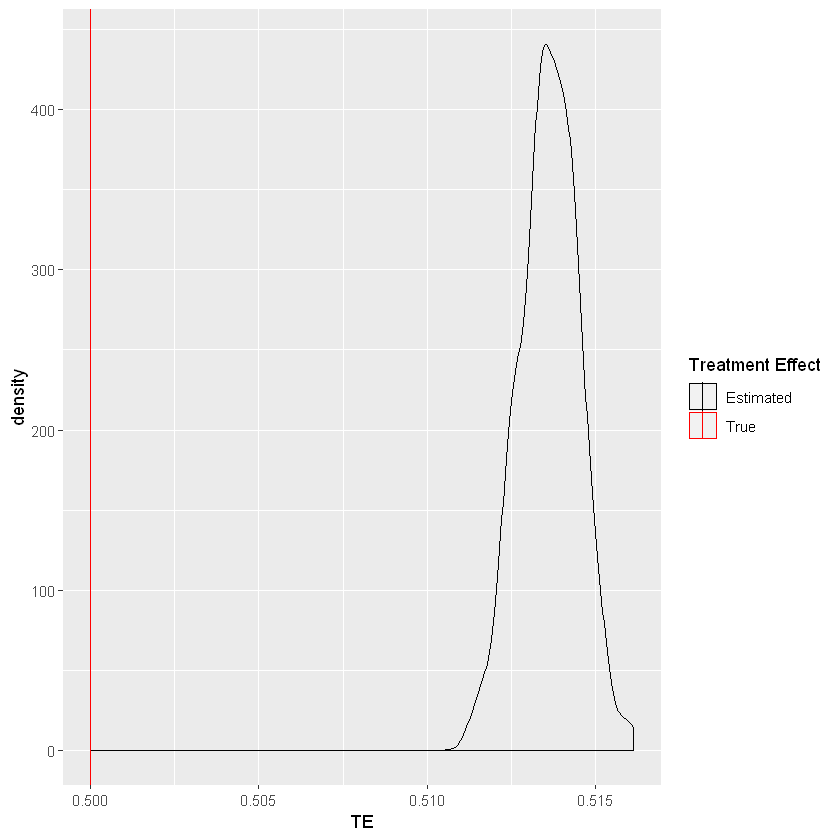

In [4]:
ggplot(data.frame(TE), aes(TE)) + geom_density(aes(color='Estimated')) + 
    geom_vline(aes(xintercept = 0.5,color='True')) +
    scale_color_manual(name = "Treatment Effect", values = c(True = "red", Estimated="black"))


## Naive Estimation Visualized

Clearly the estimate here is biased. This isn't terribly surprising as we are ignoring $m$ completely. A step in the right direction is to estimate $m$ and $g$ in a first-stage and then estimate the treatment effect from the residuals. How do we do this? First, we can build a prediction model and estimate the $g$ and $m$ functions. Once we have these, we can get the estimate for $\hat{\theta}$ by regressing $y-\hat{g}$ on $d-\hat{m}$.

Once again we can implement this in R where the models are estimated by random forests.


In [5]:

TE = array(0,dim=c(500))
pb = txtProgressBar(min = 0, max = 500, style = 3)

for (i in 1:500){

    model_dz = randomForest(z,d,maxnodes = 10, ntree = 100)
    model_yz = randomForest(z,y,maxnodes = 10, ntree = 100)

    G_old = predict(model_yz,z)
    M_old = predict(model_dz,z)

    target_w = y-G_old
    explain_v = d-M_old
    OLS = coef(lm(target_w~explain_v+0))[1]
    setTxtProgressBar(pb, i)

    TE[i] = OLS
}

close(pb)

  |======================================================================| 100%


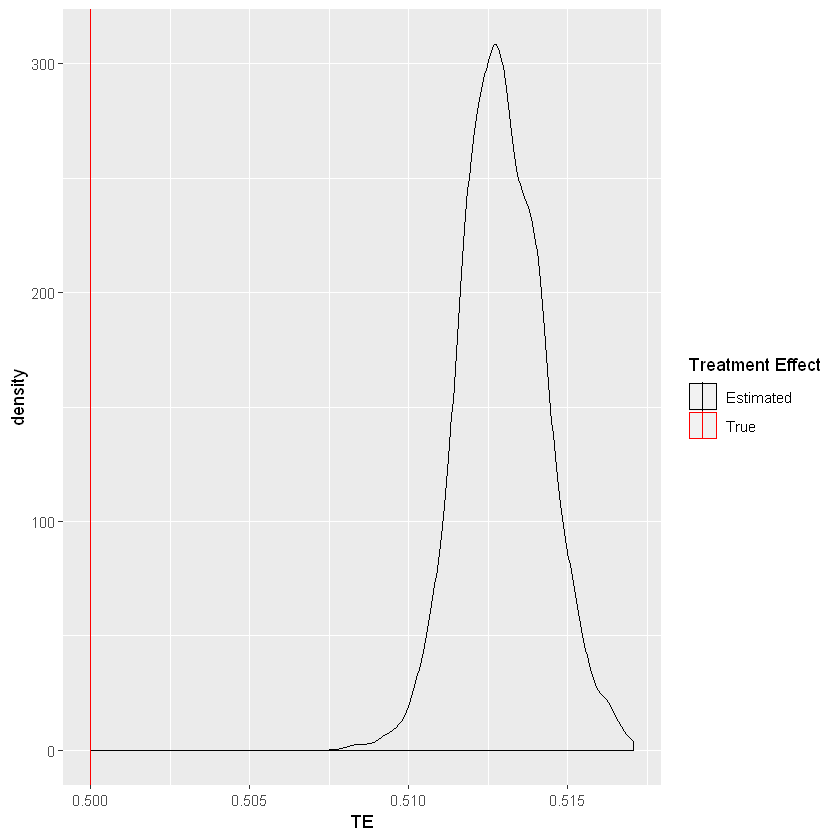

In [6]:
ggplot(data.frame(TE), aes(TE)) + geom_density(aes(color='Estimated')) + 
    geom_vline(aes(xintercept = 0.5,color='True')) +
    scale_color_manual(name = "Treatment Effect", values = c(True = "red", Estimated="black"))


## Improved but Still Naive

The estimates are still biased, though not as badly. It turns out that we can solve this by splitting our sample. The idea is to use the estimates for $m$ and $g$ obtained on different partions of the sample to compute the estimate of $\hat{\theta}$.

Using the same random forests, but including a data splitting procedure we have:

In [8]:
S = 500
maxnodes = NULL
ntree = 100

TE = array(0,dim=c(S))
pb = txtProgressBar(min = 0, max = S, style = 3)
for (i in 1:S){
    I=sort(sample(1:N,N/2))
    Ic=setdiff(1:N,I)

    model_dz1 = randomForest(z[I,],d[I], maxnodes = maxnodes, ntree = ntree)
    model_dz2 = randomForest(z[Ic,],d[Ic], maxnodes = maxnodes, ntree = ntree)

    model_yz1 = randomForest(z[I,],y[I], maxnodes = maxnodes, ntree = ntree)
    model_yz2 = randomForest(z[Ic,],y[Ic], maxnodes = maxnodes, ntree = ntree)

    target_w1 = y[I]-predict(model_yz2,z[I,])
    target_w2 = y[Ic]-predict(model_yz1,z[Ic,])

    explain_v1 = d[I]-predict(model_dz2,z[I,])
    explain_v2 = d[Ic]-predict(model_dz1,z[Ic,])

    target_w = c(target_w1, target_w2)
    explain_v = c(explain_v1, explain_v2)
    OLS = coef(lm(target_w~explain_v+0))[1]
    
    setTxtProgressBar(pb, i)

    TE[i] = OLS
}
close(pb)

  |======================================================================| 100%


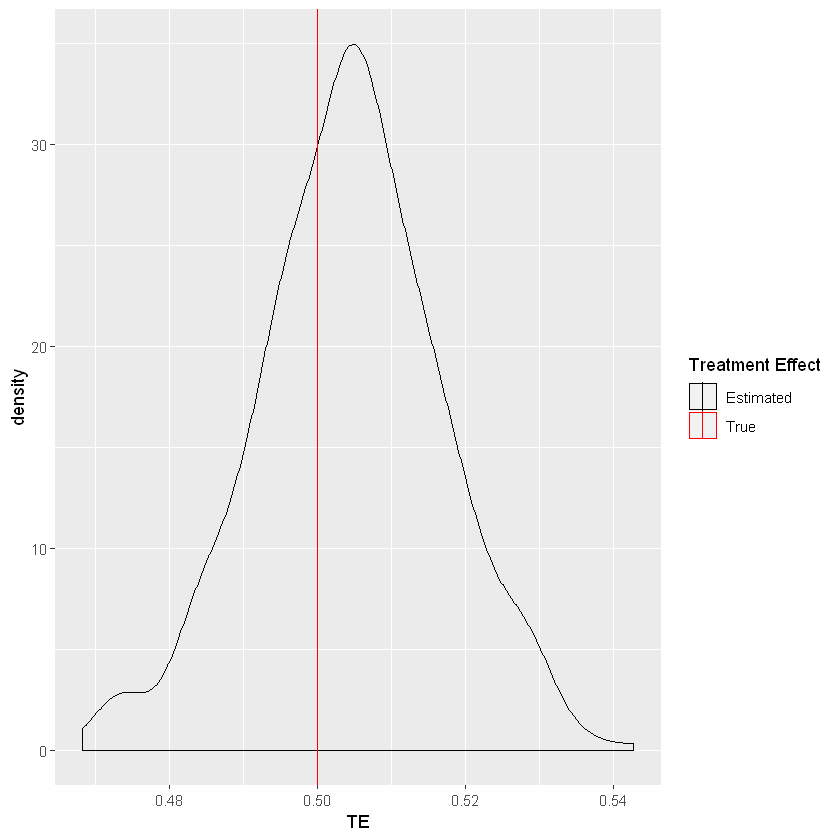

In [9]:
ggplot(data.frame(TE), aes(TE)) + geom_density(aes(color='Estimated')) + 
    geom_vline(aes(xintercept = 0.5,color='True')) +
    scale_color_manual(name = "Treatment Effect", values = c(True = "red", Estimated="black"))

## Double Machine Learning

This strategy works quite well as the bias is almost completely eliminated. Naturally the estimator will have a larger variance as it only uses half of the sample. However, one can employ other methods to reduce the dispersion of the estimator.

## Exercise: Module 6

In this module we have learned how to use random forests for causal estimation. We have seen that if we naively estimate the model there will be significant bias in the parameter of interest. However, we can correct for that bias through the use of residualizing and more importantly sample splitting. Just like we did in the random forest section we want to see how the results change if we modify the tuning parameters for the forests.

1. Re-estimate the model using double ML with different tuning parameters for the random forest
2. Change the maxnodes to 20
3. Change the number of trees to 200
4. How does this effect the results?